# Network Analysis Project - Game of Thrones

In this project I want to analyze a dataset about the famous tv serie "Game of Thrones". The story is full of characters and I want to understand if it's possible to know the importance and the evolution of each characters with a network analysis. 
The dataset reports the co-occurrence of each character, two characters are considered co-occurence if their name appear in the vicinity of 15 words.

## EDA

In [633]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
from operator import itemgetter
from networkx.algorithms.community import k_clique_communities, girvan_newman, label_propagation_communities
from seaborn import color_palette, set_style, palplot

Firstly I uploaded the dataset and tried to investigate it. We have 4 columns:
- Source: first character that appear
- Target: second character that appears within 15 words
- Type: all indirect
- Weight: number of interactions
- Book: book number

In [786]:
book1 = pd.read_csv("Downloads/book1.csv")
book1.head(10)

Source              Target        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   
5  Aemon-Targaryen-(Maester-Aemon)         Bowen-Marsh  Undirected       4   
6  Aemon-Targaryen-(Maester-Aemon)               Chett  Undirected       9   
7  Aemon-Targaryen-(Maester-Aemon)              Clydas  Undirected       5   
8  Aemon-Targaryen-(Maester-Aemon)        Jeor-Mormont  Undirected      13   
9  Aemon-Targaryen-(Maester-Aemon)            Jon-Snow  Undirected      34   

   book  
0     1  
1     1  
2     1  
3     1  
4     1  
5     1  
6     1  
7     1  
8     1  
9     1

I dropped the column book because it's useless for our purposes.

In [787]:
book1 = book1.drop(columns='book')

We have 139 unique values for sources and 143 for target.

In [788]:
book1.nunique()

Source    139
Target    143
Type        1
weight     57
dtype: int64

Then I plot the distribution of the interactions.
I noticed that the majority is beetween 0 and 15, with a median of 5 and a mean of 11.

Text(0, 0.5, 'Count')

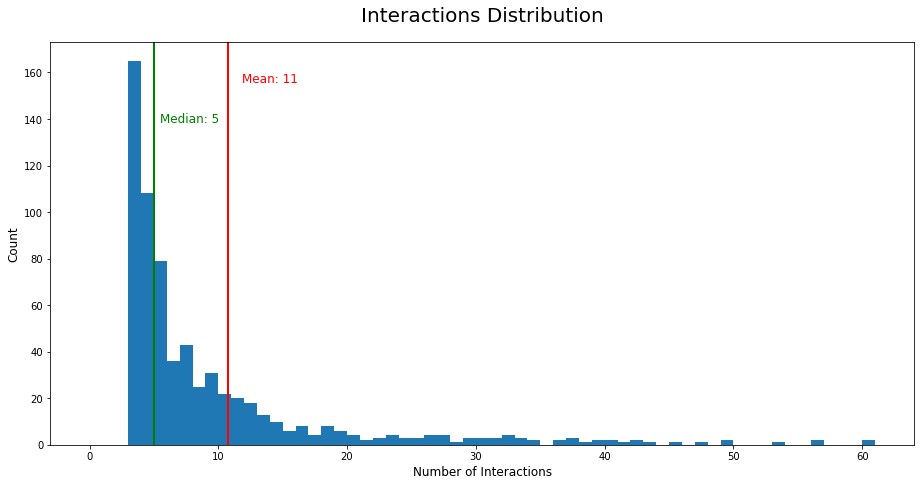

In [789]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.hist(book1["weight"], bins= range(62), histtype ="bar")
plt.axvline(book1["weight"].mean(), color="red", linestyle='-', linewidth=2 )
plt.axvline(book1["weight"].median(), color="green", linestyle='-', linewidth=2 )
min_ylim, max_ylim = plt.ylim()
plt.text(book1["weight"].mean()*1.1, max_ylim*0.9, 'Mean: {:.0f}'.format(book1["weight"].mean()), color = "red",  fontsize= 12)
plt.text(book1["weight"].median()*1.1, max_ylim*0.8, 'Median: {:.0f}'.format(book1["weight"].median()), color = "green", fontsize= 12)
ax.set_title('Interactions Distribution', fontdict={"fontsize":20}, pad = 20)
plt.xlabel("Number of Interactions", fontsize= 12, x = 0.5)
plt.ylabel("Count", fontsize= 12)


After that I group by "Source" to see if the top characters will correspond to the the ones with the highest sum of weights. The thing that I noticed is that the nodes with the highest degree are those in the column "Source" with the highest weight but I had to do the same with the "target" column and I did not have the same results.
In my opinion I can explain this fact thinking of a how a book is written. The first character that appear (source) is probabaly the one the start the conversation with another one or call the name of the second. Instead the target character can not be present even if his name appears within the 15 words.
For thi reason I decided to draw the network with the label of the top 15 Sources and with the addition of Tyrion Lannister that is one of the top target not present in sources.

In [790]:
df_by_source = book1.groupby(by=book1["Source"]).sum()
df_by_source["Source"] = df_by_source.index
label = df_by_source.nlargest(15,"weight")
label

weight              Source
Source                                        
Eddard-Stark          1013        Eddard-Stark
Bran-Stark             511          Bran-Stark
Catelyn-Stark          475       Catelyn-Stark
Arya-Stark             430          Arya-Stark
Daenerys-Targaryen     420  Daenerys-Targaryen
Cersei-Lannister       367    Cersei-Lannister
Jon-Snow               335            Jon-Snow
Joffrey-Baratheon      275   Joffrey-Baratheon
Jaime-Lannister        157     Jaime-Lannister
Barristan-Selmy        143     Barristan-Selmy
Robert-Baratheon       136    Robert-Baratheon
Drogo                  135               Drogo
Robb-Stark             120          Robb-Stark
Jeor-Mormont           119        Jeor-Mormont
Petyr-Baelish          118       Petyr-Baelish

In [792]:
df_by_target = book1.groupby(by=book1["Target"]).sum()
df_by_target["Target"]=df_by_target.index
df_by_target.nlargest(15,"weight")

weight             Target
Target                                      
Robert-Baratheon      805   Robert-Baratheon
Tyrion-Lannister      584   Tyrion-Lannister
Sansa-Stark           532        Sansa-Stark
Jon-Snow              449           Jon-Snow
Robb-Stark            396         Robb-Stark
Eddard-Stark          271       Eddard-Stark
Varys                 231              Varys
Petyr-Baelish         195      Petyr-Baelish
Tywin-Lannister       169    Tywin-Lannister
Samwell-Tarly         148      Samwell-Tarly
Joffrey-Baratheon     147  Joffrey-Baratheon
Luwin                 132              Luwin
Theon-Greyjoy         123      Theon-Greyjoy
Drogo                 121              Drogo
Jorah-Mormont         119      Jorah-Mormont

In [793]:
label = dict(label["Source"])
label["Tyrion-Lannister"] = "Tyrion-Lannister"
label

{'Eddard-Stark': 'Eddard-Stark',
 'Bran-Stark': 'Bran-Stark',
 'Catelyn-Stark': 'Catelyn-Stark',
 'Arya-Stark': 'Arya-Stark',
 'Daenerys-Targaryen': 'Daenerys-Targaryen',
 'Cersei-Lannister': 'Cersei-Lannister',
 'Jon-Snow': 'Jon-Snow',
 'Joffrey-Baratheon': 'Joffrey-Baratheon',
 'Jaime-Lannister': 'Jaime-Lannister',
 'Barristan-Selmy': 'Barristan-Selmy',
 'Robert-Baratheon': 'Robert-Baratheon',
 'Drogo': 'Drogo',
 'Robb-Stark': 'Robb-Stark',
 'Jeor-Mormont': 'Jeor-Mormont',
 'Petyr-Baelish': 'Petyr-Baelish',
 'Tyrion-Lannister': 'Tyrion-Lannister'}

 ## Analysis

I create the network and draw it.

In [893]:
G = nx.Graph()
G = nx.from_pandas_edgelist(book1, 'Source', 'Target')

In [894]:
book1["pos"] = list(zip(book1["Source"], book1["Target"]))
pos = book1.to_dict()['pos']

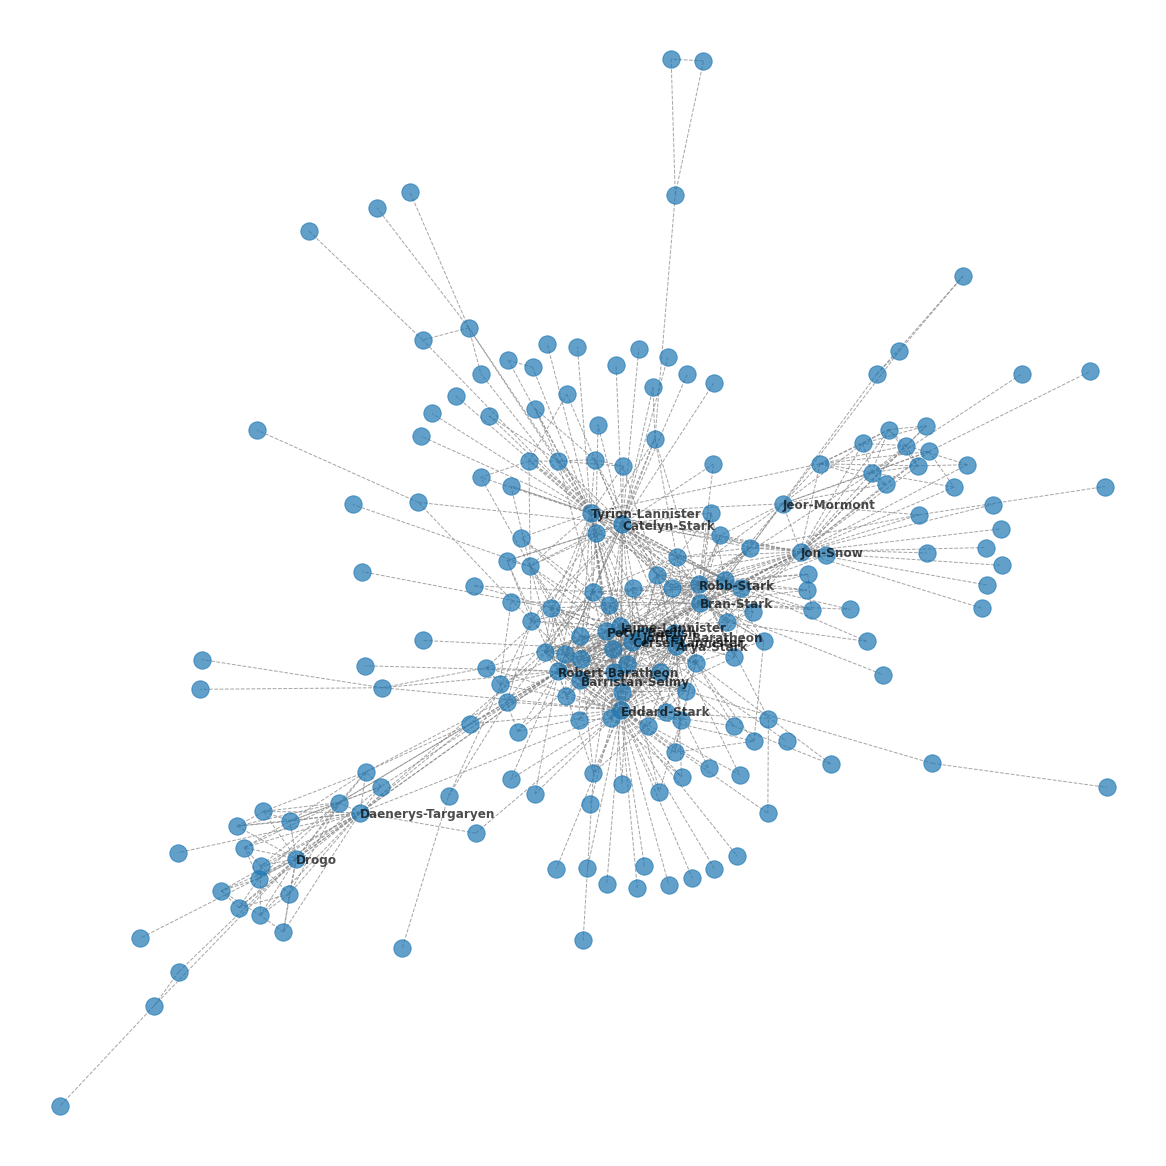

In [796]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
nx.draw(G, edge_color='grey', labels=label, font_size=12,font_weight="bold",verticalalignment="center_baseline" ,
                        horizontalalignment="left", style ="dashed", alpha=0.7)

Basic information of the network:

In [797]:
print(nx.info(G))
density = nx.density(G)
print("Network density:", density)

Name: 
Type: Graph
Number of nodes: 187
Number of edges: 684
Average degree:   7.3155
Network density: 0.03933068828704502


Then I wanted to calculate the most famous measures to analyse a network. So I calculated the degree centrality, the betweennes centrality, the eigenvector centrality and the closeness centrality for the top 5 nodes.

The results are very similar, the most importantant characters according with this measures are:
- Eddard Stark
- Robert Baratheon
- Tyrion Lannister
- Catelyn Stark

If someone read the books will know that in the first one these are the main characters. 

In [798]:
degree = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree, 'degree')
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)
closeness = nx.closeness_centrality(G)

    
sorted_degree = sorted(degree.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by degree:\n")
for d in sorted_degree[:5]:
    print(d)

    
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by betweenness centrality:\n")
for b in sorted_betweenness[:5]:
    print(b)
    
    
sorted_eigenvector = sorted(eigenvector.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by eigenvector centrality:\n")
for e in sorted_eigenvector[:5]:
    print(e)
    
sorted_closeness = sorted(closeness.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by closeness centrality:\n")
for b in sorted_closeness[:5]:
    print(b)


Top 5 nodes by degree:

('Eddard-Stark', 66)
('Robert-Baratheon', 50)
('Tyrion-Lannister', 46)
('Catelyn-Stark', 43)
('Jon-Snow', 37)

Top 5 nodes by betweenness centrality:

('Eddard-Stark', 0.2696038913836117)
('Robert-Baratheon', 0.21403028397371796)
('Tyrion-Lannister', 0.1902124972697492)
('Jon-Snow', 0.17158135899829566)
('Catelyn-Stark', 0.1513952715347627)

Top 5 nodes by eigenvector centrality:

('Eddard-Stark', 0.29640893871843454)
('Robert-Baratheon', 0.2694880017758138)
('Sansa-Stark', 0.23155019835665291)
('Tyrion-Lannister', 0.22520388145217876)
('Joffrey-Baratheon', 0.22075394589376898)

Top 5 nodes by closeness centrality:

('Eddard-Stark', 0.5636363636363636)
('Robert-Baratheon', 0.5454545454545454)
('Tyrion-Lannister', 0.510989010989011)
('Catelyn-Stark', 0.5054347826086957)
('Robb-Stark', 0.49732620320855614)


Knowing the structure of the map of the GOT world I thought that will be interesting try to detect possibile communities in the network.
To do this I decide to apply different methods:
- Louvain
- Girvan Newman
- K-Clique
- Label Propagation

## Louvain 

{'Eddard-Stark': Text(-0.01686922638968682, 0.2009530815167553, 'Eddard-Stark'),
 'Bran-Stark': Text(-0.06881315878359824, -0.05817244100477084, 'Bran-Stark'),
 'Catelyn-Stark': Text(-0.2274161956799297, 0.022170821104482336, 'Catelyn-Stark'),
 'Arya-Stark': Text(0.002843511621865521, 0.033611456089645546, 'Arya-Stark'),
 'Daenerys-Targaryen': Text(0.4316026698097109, 0.17832223448813792, 'Daenerys-Targaryen'),
 'Cersei-Lannister': Text(0.006698663951302097, 0.008893080503530555, 'Cersei-Lannister'),
 'Jon-Snow': Text(0.05087023615083639, -0.2095502107827485, 'Jon-Snow'),
 'Joffrey-Baratheon': Text(-0.002364460950057034, 0.04763780918458225, 'Joffrey-Baratheon'),
 'Jaime-Lannister': Text(-0.11154259647981629, 0.06362664221215687, 'Jaime-Lannister'),
 'Barristan-Selmy': Text(0.022554024130331925, 0.11064425137640545, 'Barristan-Selmy'),
 'Robert-Baratheon': Text(0.06863544734044189, 0.0982539882503659, 'Robert-Baratheon'),
 'Drogo': Text(0.5716708117127138, 0.11201043716037144, 'Drogo')

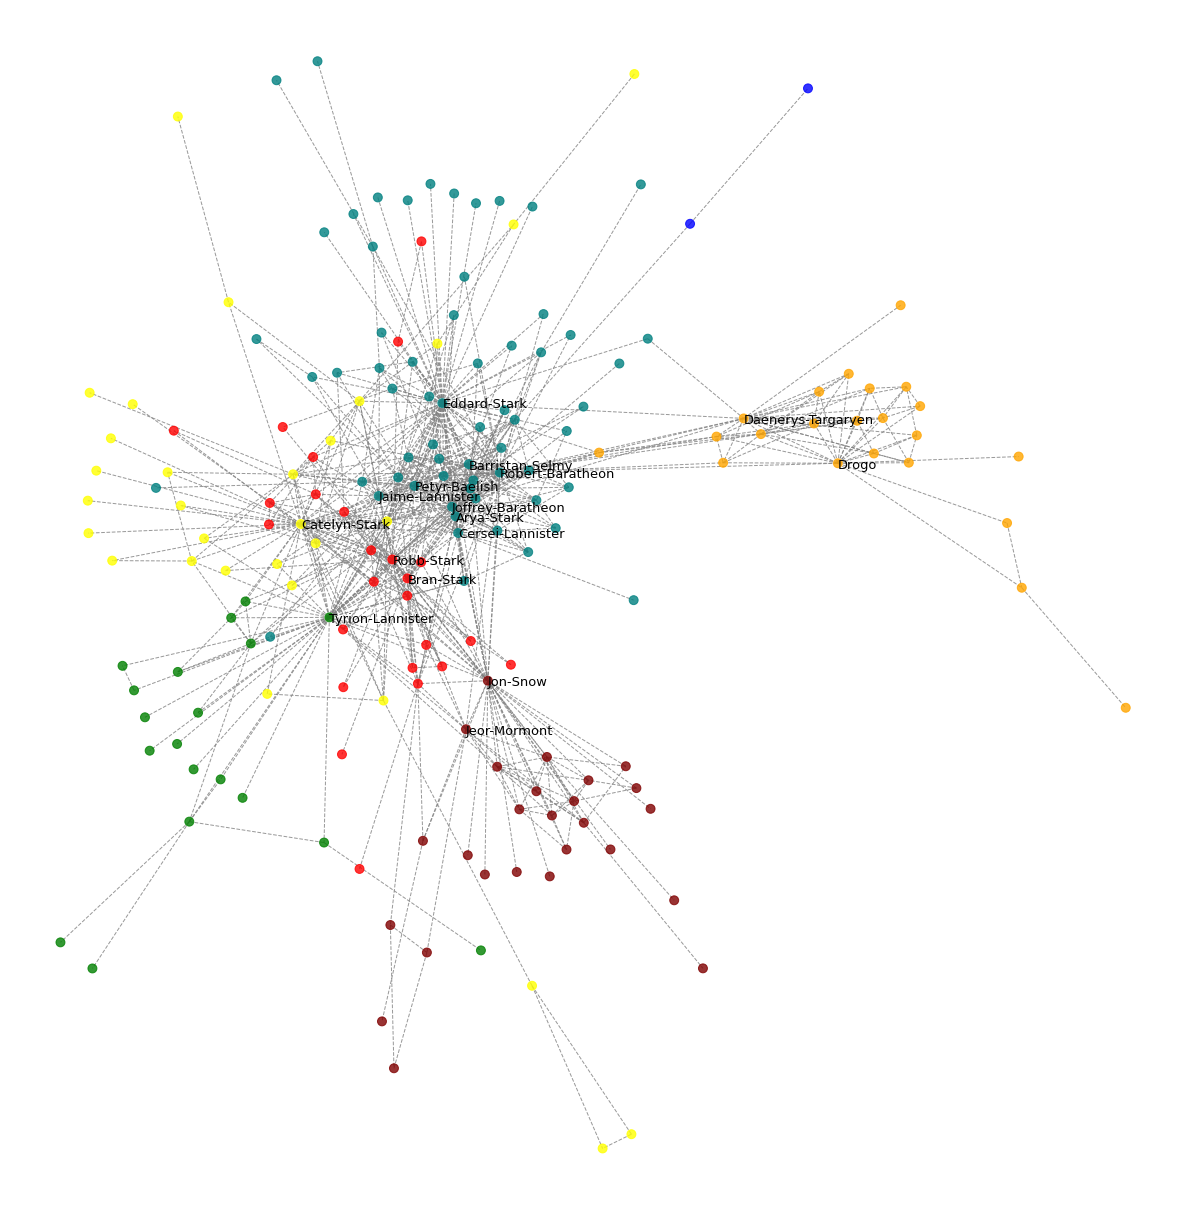

In [834]:
fig, ax = plt.subplots(figsize=(21,22))
partition = community_louvain.best_partition(G, resolution=0.95, random_state=100)
unique_community = np.unique(list(partition.values()))
unique_community
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'red', 
    3 : 'orange',
    4 : 'green',
    5 : 'yellow',
    6 : "blue"
}

node_cmap = [cmap[v] for _ ,v in partition.items()]

pos = nx.spring_layout(G)

nx.draw(G, pos, node_size = 80, alpha = 0.8, edge_color='grey', style ="dashed", 
        node_color=node_cmap)
nx.draw_networkx_labels(G, pos, labels=label, font_size=13 ,alpha=2, verticalalignment="center_baseline" ,
                        horizontalalignment="left")

## Girvan Newman

In [800]:
# Code from GitHub:
# https://github.com/learn-co-students/dsc-3-28-12-graph-connectivity-community-detection-data-science-demo
community = girvan_newman(G)
comm_iter1 = tuple(sorted(c) for c in next(community))
dict(enumerate(comm_iter1))
comm1 = community
community_map = {}
for node in G.nodes():
    for i, comm1 in enumerate(comm_iter1):
        if node in comm1:
            community_map[node] = i
    if community_map.get(node, None) is None:
        community_map[node] = None

for k, v in community_map.items():
    G.nodes[k]['community'] = v
community_map

def create_color_map(G, attribute, seaborn_palette="colorblind"):

    attr = [G.nodes[label][attribute] for label in G.nodes()]
    # get the set of possible attributes
    attr_uniq = list(set(attr))
    vals = len(attr_uniq)
    # generate color palette from seaborn
    palette = color_palette(seaborn_palette, vals).as_hex()
    # create a mapping of attribute to color
    cmap = dict(zip(attr_uniq, palette))
    # map the attribute for each node to the color it represents
    colors = [cmap[attr] for attr in attr]

    return colors, cmap, palette

{'Eddard-Stark': Text(0.03845525899132692, -0.04328820541125249, 'Eddard-Stark'),
 'Bran-Stark': Text(0.1458737337487869, 0.04639256192511547, 'Bran-Stark'),
 'Catelyn-Stark': Text(0.18438716866554708, -0.025148383179565127, 'Catelyn-Stark'),
 'Arya-Stark': Text(0.024829093493561365, -0.03612075694789804, 'Arya-Stark'),
 'Daenerys-Targaryen': Text(-0.39170567382658733, 0.11117810325632599, 'Daenerys-Targaryen'),
 'Cersei-Lannister': Text(0.010953746239679324, -0.002934235503153204, 'Cersei-Lannister'),
 'Jon-Snow': Text(0.058270136783202385, 0.16858872724292273, 'Jon-Snow'),
 'Joffrey-Baratheon': Text(0.003163421463063943, -0.015734943971268435, 'Joffrey-Baratheon'),
 'Jaime-Lannister': Text(0.06241414115379179, -0.12354142427664791, 'Jaime-Lannister'),
 'Barristan-Selmy': Text(-0.04696493801750921, -0.08806355833757208, 'Barristan-Selmy'),
 'Robert-Baratheon': Text(-0.08360216612369203, -0.01643751270824591, 'Robert-Baratheon'),
 'Drogo': Text(-0.5218649622940783, 0.14867642401578823,

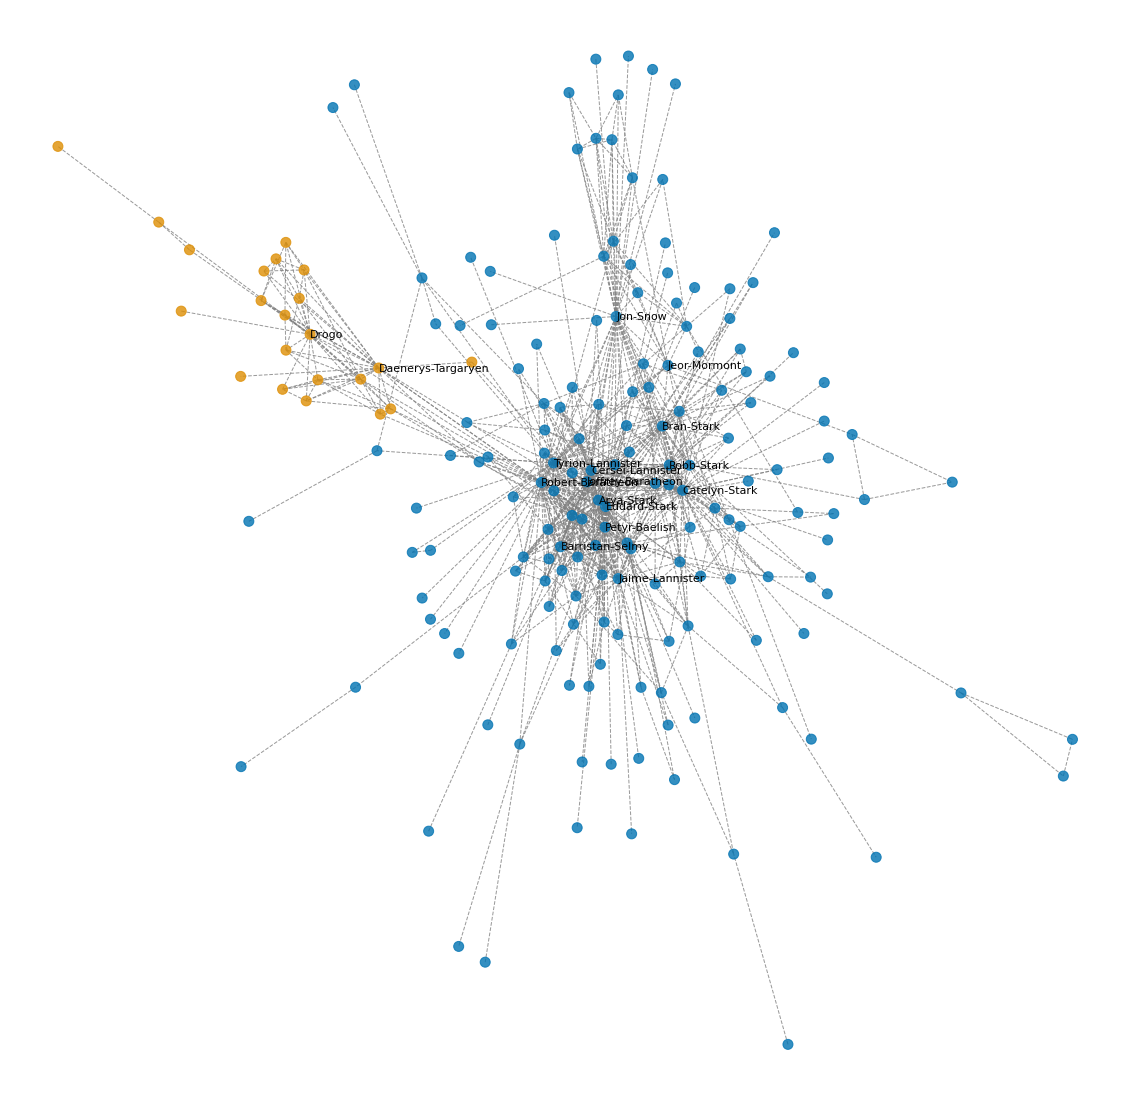

In [815]:
# Plot Figure
fig, ax = plt.subplots(figsize=(20,20))
node_colors, color_map, palette = create_color_map(G, 'community')
nx.draw(G, pos, node_size = 100, alpha = 0.8, edge_color='grey', style ="dashed",node_color=node_colors)
nx.draw_networkx_labels(G, pos, labels=label, font_size=11, alpha=2, horizontalalignment="left")

## K_Clique

In [874]:
comm = k_clique_communities(G, 5, cliques=None)
community_clique = list(k_clique_communities(G, 5, cliques=None))
comm2 = comm
community_map2 = {}
for node in G.nodes():
    for i, comm2 in enumerate(community_clique):
        if node in comm2:
            community_map2[node] = i
    if community_map2.get(node, None) is None:
        community_map2[node] = None
for k, v in community_map2.items():
    G.nodes[k]['comm'] = v

In [875]:
def create_color_map(G, attribute, seaborn_palette="colorblind"):

    attr = [G.nodes[label][attribute] for label in G.nodes()]
    # get the set of possible attributes
    attr_uniq = list(set(attr))
    vals = len(attr_uniq)
    # generate color palette from seaborn
    palette = color_palette(seaborn_palette, vals).as_hex()
    # create a mapping of attribute to color
    cmap = dict(zip(attr_uniq, palette))
    # map the attribute for each node to the color it represents
    colors = [cmap[attr] for attr in attr]

    return colors, cmap, palette

{'Eddard-Stark': Text(-0.01686922638968682, 0.2009530815167553, 'Eddard-Stark'),
 'Bran-Stark': Text(-0.06881315878359824, -0.05817244100477084, 'Bran-Stark'),
 'Catelyn-Stark': Text(-0.2274161956799297, 0.022170821104482336, 'Catelyn-Stark'),
 'Arya-Stark': Text(0.002843511621865521, 0.033611456089645546, 'Arya-Stark'),
 'Daenerys-Targaryen': Text(0.4316026698097109, 0.17832223448813792, 'Daenerys-Targaryen'),
 'Cersei-Lannister': Text(0.006698663951302097, 0.008893080503530555, 'Cersei-Lannister'),
 'Jon-Snow': Text(0.05087023615083639, -0.2095502107827485, 'Jon-Snow'),
 'Joffrey-Baratheon': Text(-0.002364460950057034, 0.04763780918458225, 'Joffrey-Baratheon'),
 'Jaime-Lannister': Text(-0.11154259647981629, 0.06362664221215687, 'Jaime-Lannister'),
 'Barristan-Selmy': Text(0.022554024130331925, 0.11064425137640545, 'Barristan-Selmy'),
 'Robert-Baratheon': Text(0.06863544734044189, 0.0982539882503659, 'Robert-Baratheon'),
 'Drogo': Text(0.5716708117127138, 0.11201043716037144, 'Drogo')

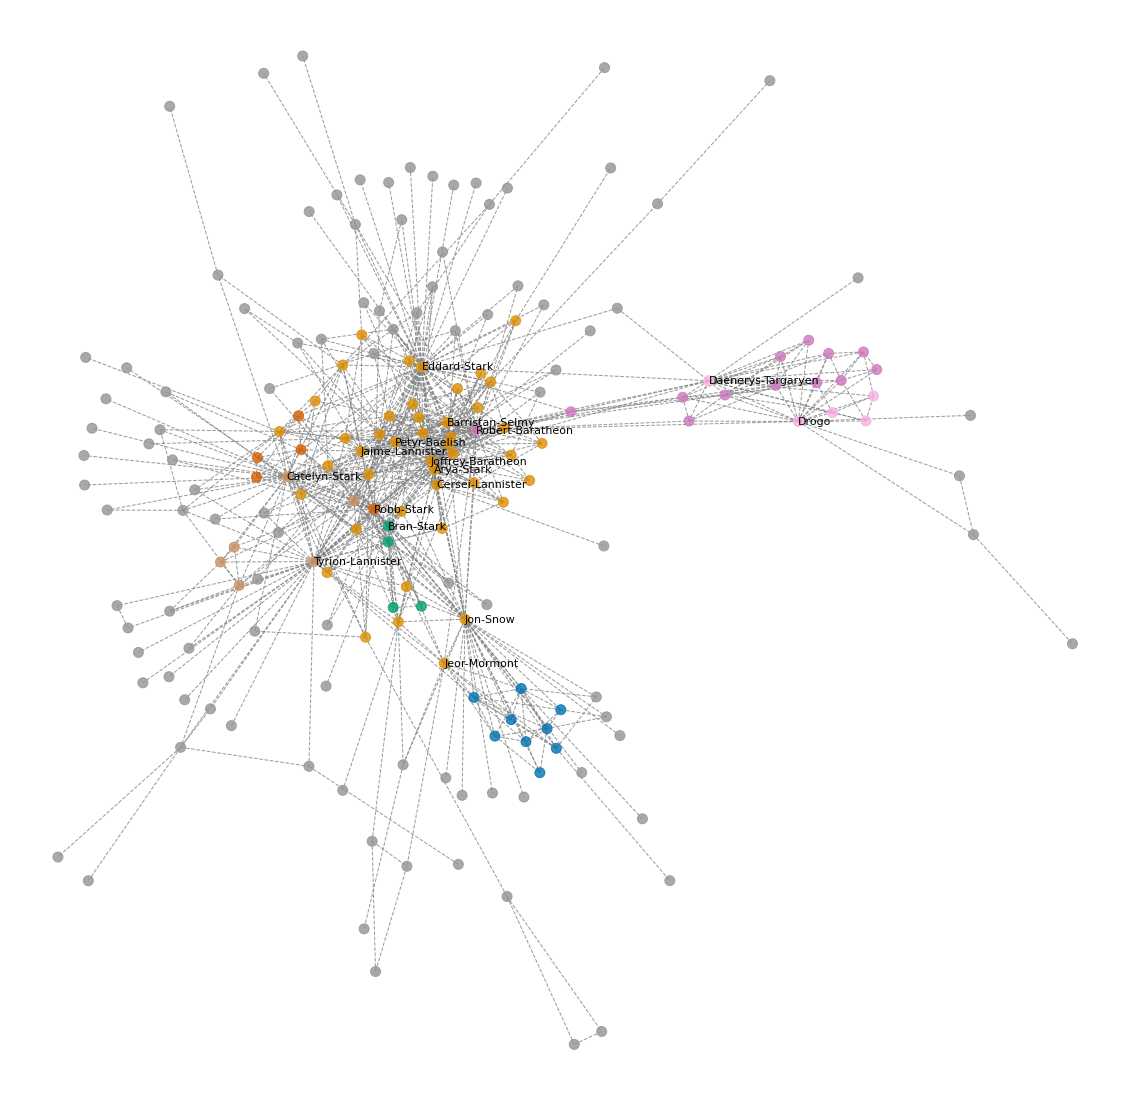

In [876]:
# Plot Figure
fig, ax = plt.subplots(figsize=(20,20))
node_colors, color_map, palette = create_color_map(G, 'comm')
nx.draw(G, pos, node_size = 100, alpha = 0.8, edge_color='grey', style ="dashed",node_color=node_colors)
nx.draw_networkx_labels(G, pos, labels=label, font_size=11, alpha=2, horizontalalignment="left")

## Label Propagation

In [819]:
comm_lab = label_propagation_communities(G)
community_lab = list(label_propagation_communities(G))
comm3 = comm_lab
community_map3 = {}
for node in G.nodes():
    for i, comm3 in enumerate(community_lab):
        if node in comm3:
            community_map3[node] = i
    if community_map3.get(node, None) is None:
        community_map3[node] = None
for k, v in community_map3.items():
    G.nodes[k]['comm'] = v

{'Eddard-Stark': Text(0.03845525899132692, -0.04328820541125249, 'Eddard-Stark'),
 'Bran-Stark': Text(0.1458737337487869, 0.04639256192511547, 'Bran-Stark'),
 'Catelyn-Stark': Text(0.18438716866554708, -0.025148383179565127, 'Catelyn-Stark'),
 'Arya-Stark': Text(0.024829093493561365, -0.03612075694789804, 'Arya-Stark'),
 'Daenerys-Targaryen': Text(-0.39170567382658733, 0.11117810325632599, 'Daenerys-Targaryen'),
 'Cersei-Lannister': Text(0.010953746239679324, -0.002934235503153204, 'Cersei-Lannister'),
 'Jon-Snow': Text(0.058270136783202385, 0.16858872724292273, 'Jon-Snow'),
 'Joffrey-Baratheon': Text(0.003163421463063943, -0.015734943971268435, 'Joffrey-Baratheon'),
 'Jaime-Lannister': Text(0.06241414115379179, -0.12354142427664791, 'Jaime-Lannister'),
 'Barristan-Selmy': Text(-0.04696493801750921, -0.08806355833757208, 'Barristan-Selmy'),
 'Robert-Baratheon': Text(-0.08360216612369203, -0.01643751270824591, 'Robert-Baratheon'),
 'Drogo': Text(-0.5218649622940783, 0.14867642401578823,

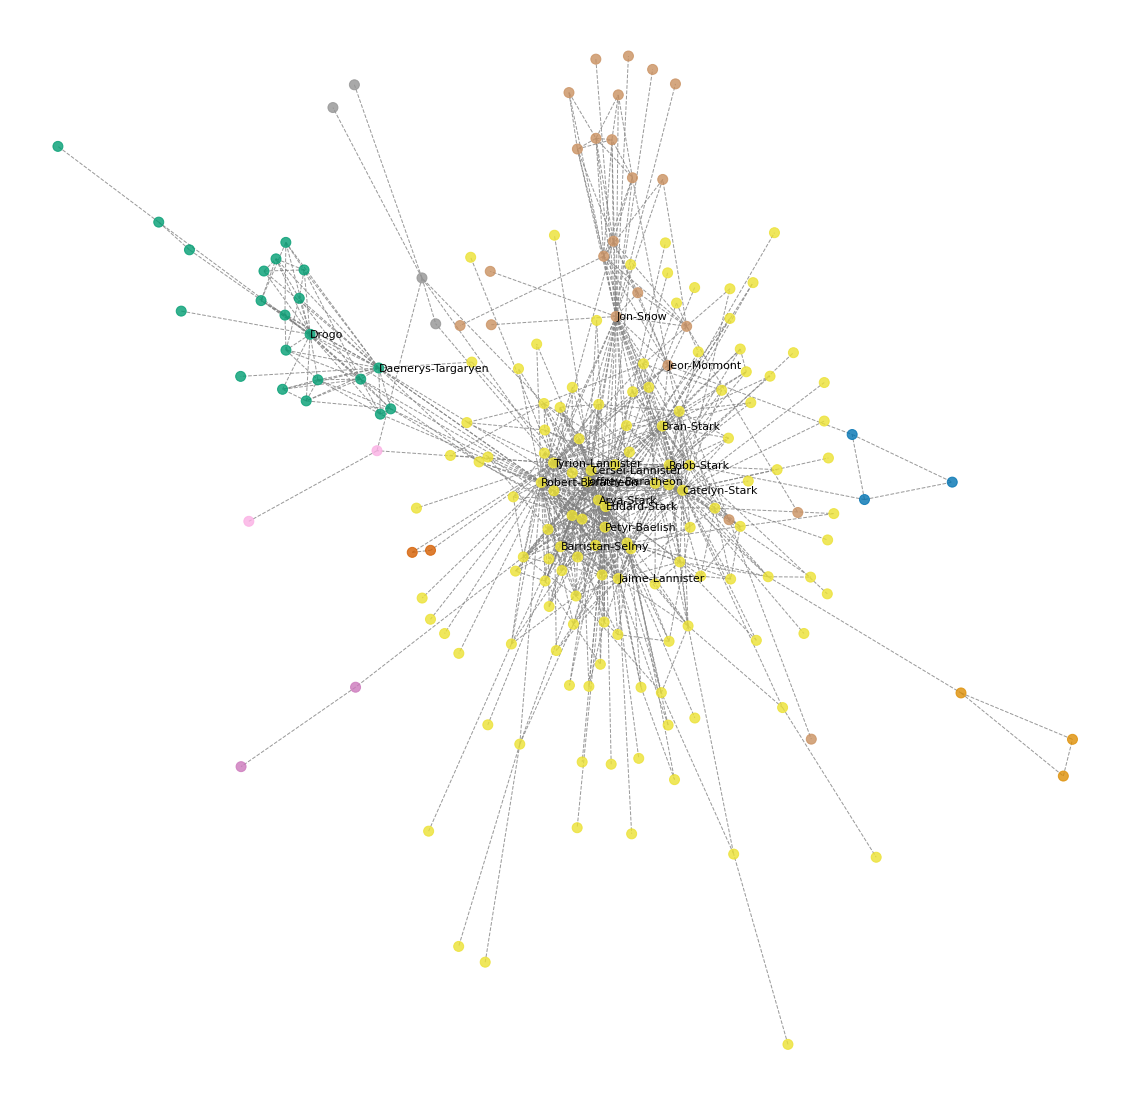

In [820]:
# Plot Figure
fig, ax = plt.subplots(figsize=(20,20))
node_colors, color_map, palette = create_color_map(G, 'comm')
nx.draw(G, pos, node_size = 100, alpha = 0.8, edge_color='grey', style ="dashed",node_color=node_colors)
nx.draw_networkx_labels(G, pos, labels=label, font_size=11, alpha=2, horizontalalignment="left")

## Book 2

Now I do the same thing to understand if things will change in book 2 or will be the same.

In [806]:
book2 = pd.read_csv("Downloads/book2.csv")
book2.head(10)

Source                           Target  \
0                Aegon-I-Targaryen                     Harren-Hoare   
1                Aegon-I-Targaryen                              Nan   
2                Aegon-I-Targaryen                Rhaenys-Targaryen   
3                Aegon-I-Targaryen                 Tyrion-Lannister   
4                Aegon-I-Targaryen                Visenya-Targaryen   
5                Aegon-V-Targaryen  Aemon-Targaryen-(Maester-Aemon)   
6  Aemon-Targaryen-(Maester-Aemon)              Daeron-II-Targaryen   
7  Aemon-Targaryen-(Maester-Aemon)                     Jeor-Mormont   
8  Aemon-Targaryen-(Maester-Aemon)                         Jon-Snow   
9  Aemon-Targaryen-(Maester-Aemon)               Maekar-I-Targaryen   

         Type  weight  book  
0  Undirected       4   2.0  
1  Undirected       3   2.0  
2  Undirected       4   2.0  
3  Undirected       3   2.0  
4  Undirected       3   2.0  
5  Undirected       3   2.0  
6  Undirected       3   2.0  
7  Undirected       9   2.0  
8  Undirected      11   2.0  
9  Undirected       3   2.0

We have more sources and targets, this means that we have more characters in this book or at least more interactions.

In [756]:
book2 = book2.drop(columns='book')
book2.nunique()

Source    193
Target    186
Type        1
weight     46
dtype: int64

We have the same median but a lower mean equal to 8.

Text(0, 0.5, 'Count')

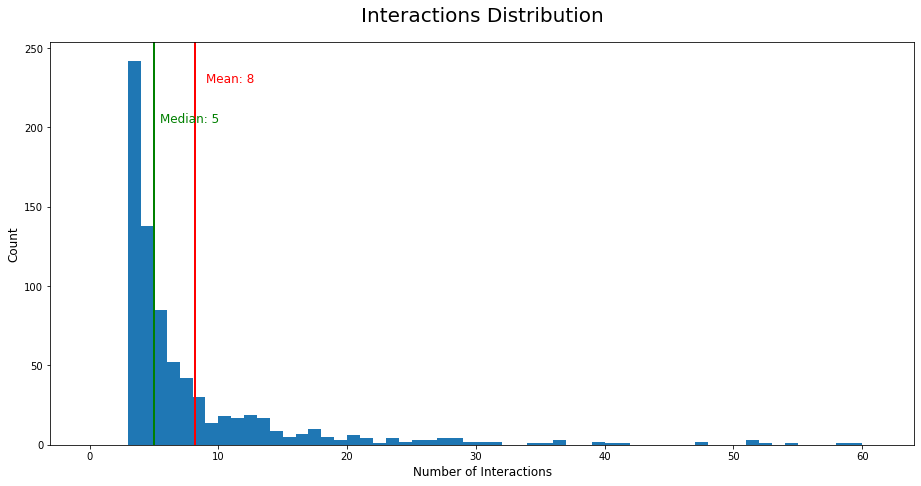

In [757]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.hist(book2["weight"], bins= range(62), histtype ="bar")
plt.axvline(book2["weight"].mean(), color="red", linestyle='-', linewidth=2 )
plt.axvline(book2["weight"].median(), color="green", linestyle='-', linewidth=2 )
min_ylim, max_ylim = plt.ylim()
plt.text(book2["weight"].mean()*1.1, max_ylim*0.9, 'Mean: {:.0f}'.format(book2["weight"].mean()), color = "red",  fontsize= 12)
plt.text(book2["weight"].median()*1.1, max_ylim*0.8, 'Median: {:.0f}'.format(book2["weight"].median()), color = "green", fontsize= 12)
ax.set_title('Interactions Distribution', fontdict={"fontsize":20}, pad = 20)
plt.xlabel("Number of Interactions", fontsize= 12, x = 0.5)
plt.ylabel("Count", fontsize= 12)


In [825]:
df2_by_source = book2.groupby(by=book2["Source"]).sum()
df2_by_source["Source"] = df2_by_source.index
label2 = df2_by_source.nlargest(20,"weight")
label2

weight  book              Source
Source                                              
Cersei-Lannister       467  74.0    Cersei-Lannister
Bran-Stark             465  54.0          Bran-Stark
Joffrey-Baratheon      426  48.0   Joffrey-Baratheon
Arya-Stark             403  74.0          Arya-Stark
Catelyn-Stark          273  58.0       Catelyn-Stark
Jon-Snow               174  26.0            Jon-Snow
Renly-Baratheon        150  16.0     Renly-Baratheon
Eddard-Stark           122  30.0        Eddard-Stark
Daenerys-Targaryen     118  30.0  Daenerys-Targaryen
Davos-Seaworth         114  18.0      Davos-Seaworth
Jeor-Mormont           113  14.0        Jeor-Mormont
Jaime-Lannister        105  28.0     Jaime-Lannister
Robb-Stark             104  24.0          Robb-Stark
Petyr-Baelish           97  14.0       Petyr-Baelish
Brienne-of-Tarth        96  20.0    Brienne-of-Tarth
Bronn                   94  20.0               Bronn
Amory-Lorch             86  36.0         Amory-Lorch
Cressen                 80  18.0             Cressen
Tyrion-Lannister        79   8.0    Tyrion-Lannister
Craster                 73  14.0             Craster

In [826]:
df2_by_target = book2.groupby(by=book2["Target"]).sum()
df2_by_target["Target"]=df2_by_target.index 
df_by_target.nlargest(20,"weight")

weight             Target
Target                                      
Robert-Baratheon      805   Robert-Baratheon
Tyrion-Lannister      584   Tyrion-Lannister
Sansa-Stark           532        Sansa-Stark
Jon-Snow              449           Jon-Snow
Robb-Stark            396         Robb-Stark
Eddard-Stark          271       Eddard-Stark
Varys                 231              Varys
Petyr-Baelish         195      Petyr-Baelish
Tywin-Lannister       169    Tywin-Lannister
Samwell-Tarly         148      Samwell-Tarly
Joffrey-Baratheon     147  Joffrey-Baratheon
Luwin                 132              Luwin
Theon-Greyjoy         123      Theon-Greyjoy
Drogo                 121              Drogo
Jorah-Mormont         119      Jorah-Mormont
Sandor-Clegane        107     Sandor-Clegane
Viserys-Targaryen     105  Viserys-Targaryen
Rodrik-Cassel         101      Rodrik-Cassel
Renly-Baratheon        97    Renly-Baratheon
Stannis-Baratheon      96  Stannis-Baratheon

In [827]:
label2 = dict(label2["Source"])
label2

{'Cersei-Lannister': 'Cersei-Lannister',
 'Bran-Stark': 'Bran-Stark',
 'Joffrey-Baratheon': 'Joffrey-Baratheon',
 'Arya-Stark': 'Arya-Stark',
 'Catelyn-Stark': 'Catelyn-Stark',
 'Jon-Snow': 'Jon-Snow',
 'Renly-Baratheon': 'Renly-Baratheon',
 'Eddard-Stark': 'Eddard-Stark',
 'Daenerys-Targaryen': 'Daenerys-Targaryen',
 'Davos-Seaworth': 'Davos-Seaworth',
 'Jeor-Mormont': 'Jeor-Mormont',
 'Jaime-Lannister': 'Jaime-Lannister',
 'Robb-Stark': 'Robb-Stark',
 'Petyr-Baelish': 'Petyr-Baelish',
 'Brienne-of-Tarth': 'Brienne-of-Tarth',
 'Bronn': 'Bronn',
 'Amory-Lorch': 'Amory-Lorch',
 'Cressen': 'Cressen',
 'Tyrion-Lannister': 'Tyrion-Lannister',
 'Craster': 'Craster'}

# Analysis

In [828]:
G2 = nx.Graph()
G2 = nx.from_pandas_edgelist(book2, 'Source', 'Target')

In [829]:
book2["pos"] = list(zip(book2["Source"], book2["Target"]))
pos2 = book2.to_dict()['pos']

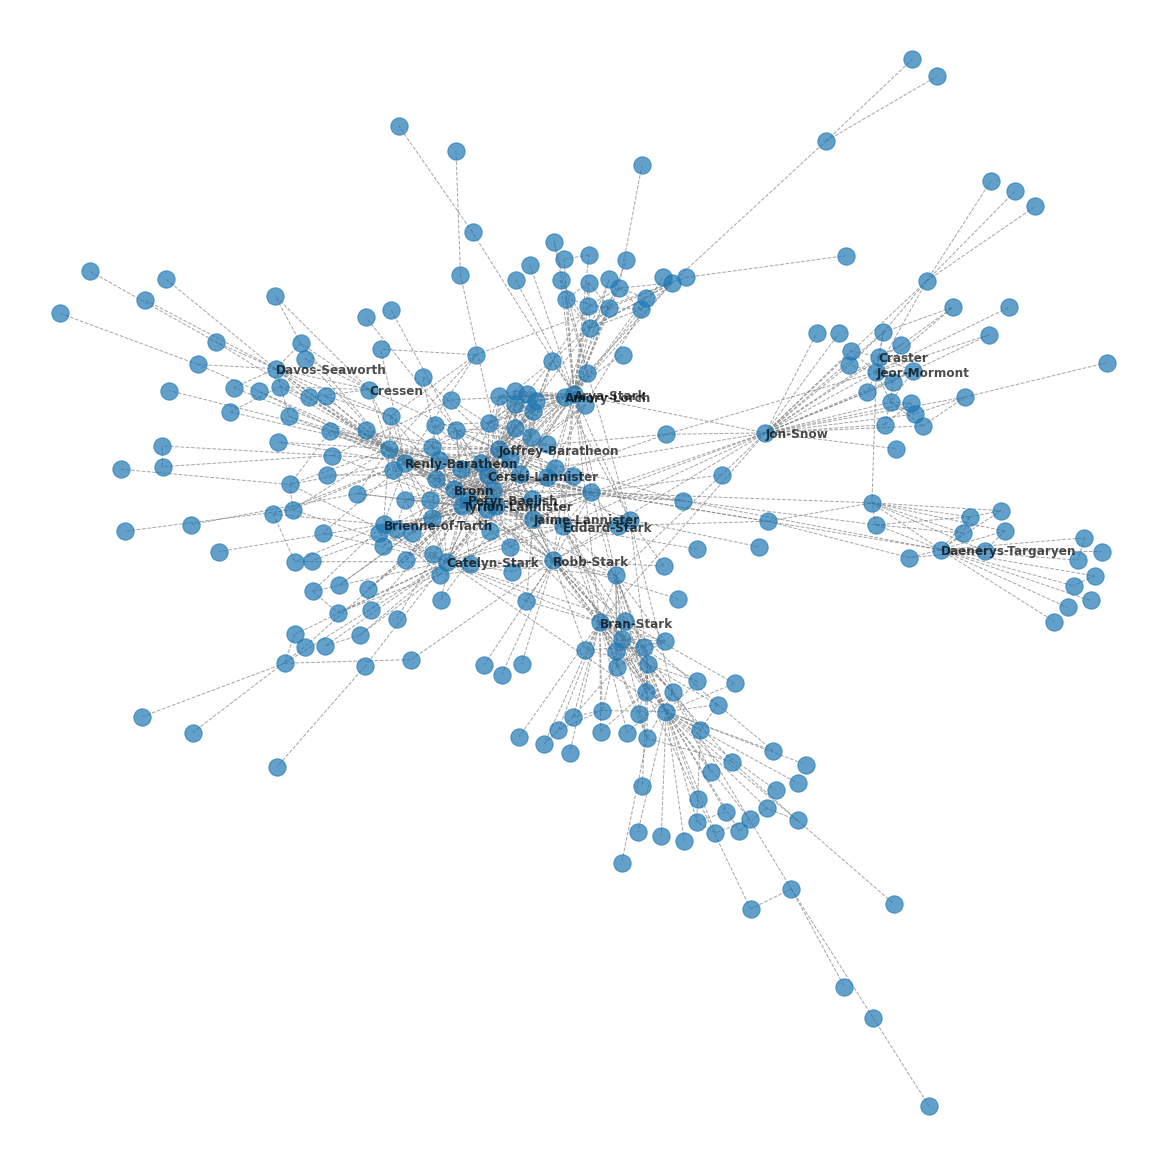

In [831]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
nx.draw(G2, edge_color='grey', labels=label2, font_size=12, font_weight="bold",verticalalignment="center_baseline",
                        horizontalalignment="left", style ="dashed", alpha=0.7)


In [832]:
print(nx.info(G2))
density2 = nx.density(G2)
print("Network density:", density2)

Name: 
Type: Graph
Number of nodes: 259
Number of edges: 775
Average degree:   5.9846
Network density: 0.02319595342851157


Now we noticed that the measures indacate different characters as the more important and there are more differences. We can explain this fact with the fragmentation of the story line in book 2. In fact we have parallel stories evolution in different region of the map, so the measures can indicate different charcters.

In [777]:
degree2 = dict(G2.degree(G2.nodes()))
nx.set_node_attributes(G2, degree2, 'degree')
betweenness2 = nx.betweenness_centrality(G2)
eigenvector2 = nx.eigenvector_centrality(G2)
closeness2 = nx.closeness_centrality(G2)

    
sorted_degree2 = sorted(degree2.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by degree:\n")
for d in sorted_degree2[:5]:
    print(d)

    
sorted_betweenness2 = sorted(betweenness2.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by betweenness centrality:\n")
for b in sorted_betweenness2[:5]:
    print(b)
    
    
sorted_eigenvector2 = sorted(eigenvector2.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by eigenvector centrality:\n")
for e in sorted_eigenvector2[:5]:
    print(e)
    
sorted_closeness2 = sorted(closeness2.items(), key=itemgetter(1), reverse=True)
print("\nTop 5 nodes by closeness centrality:\n")
for b in sorted_closeness2[:5]:
    print(b)


Top 5 nodes by degree:

('Tyrion-Lannister', 53)
('Joffrey-Baratheon', 47)
('Cersei-Lannister', 43)
('Arya-Stark', 40)
('Stannis-Baratheon', 37)

Top 5 nodes by betweenness centrality:

('Arya-Stark', 0.1881116846731781)
('Jon-Snow', 0.17443976935054054)
('Robb-Stark', 0.1649406213117506)
('Tyrion-Lannister', 0.15532375650368552)
('Robert-Baratheon', 0.15374366220396257)

Top 5 nodes by eigenvector centrality:

('Joffrey-Baratheon', 0.30736108791198014)
('Cersei-Lannister', 0.29520593493014335)
('Tyrion-Lannister', 0.28264104404537244)
('Robb-Stark', 0.21024182292838975)
('Sansa-Stark', 0.20612392410378477)

Top 5 nodes by closeness centrality:

('Robb-Stark', 0.4777777777777778)
('Eddard-Stark', 0.4574468085106383)
('Robert-Baratheon', 0.44869565217391305)
('Jaime-Lannister', 0.44714038128249567)
('Tyrion-Lannister', 0.4440619621342513)


## Louvain

{'Cersei-Lannister': Text(-0.13322125095914528, -0.06154369055208143, 'Cersei-Lannister'),
 'Bran-Stark': Text(0.11852348349006224, 0.18464059510836484, 'Bran-Stark'),
 'Joffrey-Baratheon': Text(-0.1456728607536117, -0.04613158023455845, 'Joffrey-Baratheon'),
 'Arya-Stark': Text(-0.21680016333110474, -0.005007225725029771, 'Arya-Stark'),
 'Catelyn-Stark': Text(0.028294217462279673, 0.06856590493728973, 'Catelyn-Stark'),
 'Jon-Snow': Text(0.233942671626319, -0.16573397559290154, 'Jon-Snow'),
 'Renly-Baratheon': Text(-0.09752994185963419, 0.12605608191958112, 'Renly-Baratheon'),
 'Eddard-Stark': Text(0.023062161895793146, 0.021135533727420882, 'Eddard-Stark'),
 'Daenerys-Targaryen': Text(-0.054474315224643466, -0.576896057877779, 'Daenerys-Targaryen'),
 'Davos-Seaworth': Text(-0.25573440288093063, 0.2813860885979777, 'Davos-Seaworth'),
 'Jeor-Mormont': Text(0.33663129096131816, -0.32735951430000426, 'Jeor-Mormont'),
 'Jaime-Lannister': Text(0.007019919080145627, 0.013237972943528886, 'Ja

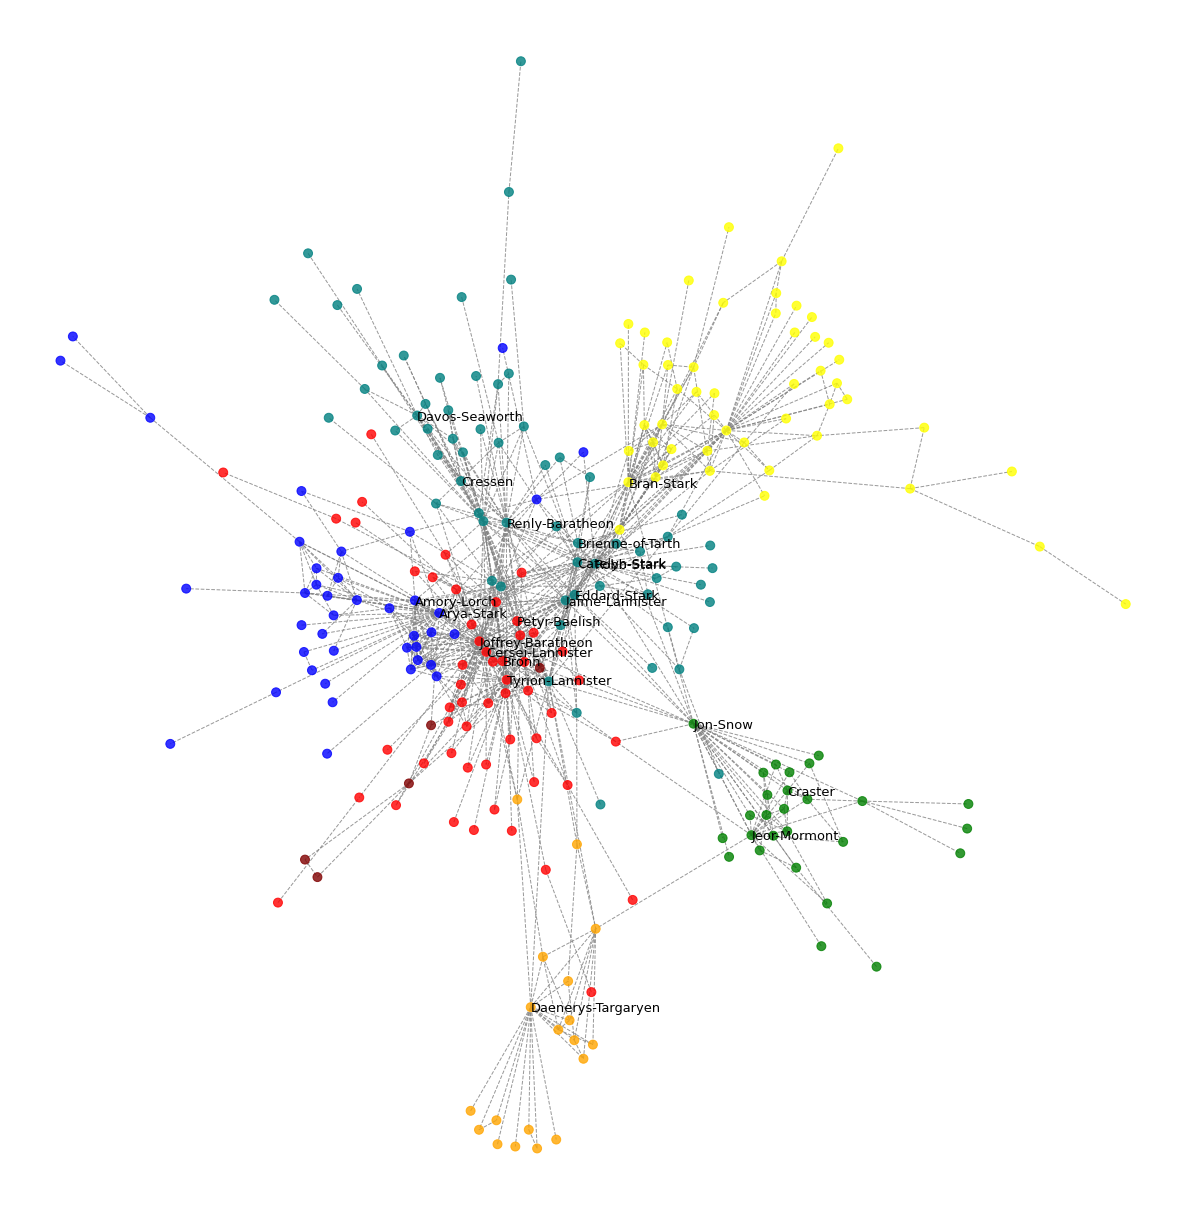

In [836]:
fig, ax = plt.subplots(figsize=(21,22))
partition2 = community_louvain.best_partition(G2, resolution=0.95, random_state=100)
unique_community2 = np.unique(list(partition2.values()))
unique_community2
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'red', 
    3 : 'orange',
    4 : 'green',
    5 : 'yellow',
    6 : "blue"
}

node_cmap2 = [cmap[v] for _ ,v in partition2.items()]

pos2 = nx.spring_layout(G2)

nx.draw(G2, pos2, node_size = 80, alpha = 0.8, edge_color='grey', style ="dashed", 
        node_color=node_cmap2)
nx.draw_networkx_labels(G2, pos2, labels=label2, font_size=13 ,alpha=2, verticalalignment="center_baseline" ,
                        horizontalalignment="left")

## Girvan Newman

In [877]:
# Code from GitHub:
# https://github.com/learn-co-students/dsc-3-28-12-graph-connectivity-community-detection-data-science-demo
community2 = girvan_newman(G2)
comm_iter2 = tuple(sorted(c) for c in next(community2))
dict(enumerate(comm_iter2))
comm2 = community2
community_map2 = {}
for node in G2.nodes():
    for i, comm2 in enumerate(comm_iter2):
        if node in comm2:
            community_map2[node] = i
    if community_map2.get(node, None) is None:
        community_map2[node] = None

for k, v in community_map2.items():
    G2.nodes[k]['community'] = v
community_map2

def create_color_map(G2, attribute, seaborn_palette="colorblind"):

    attr = [G2.nodes[label][attribute] for label in G2.nodes()]
    # get the set of possible attributes
    attr_uniq = list(set(attr))
    vals = len(attr_uniq)
    # generate color palette from seaborn
    palette = color_palette(seaborn_palette, vals).as_hex()
    # create a mapping of attribute to color
    cmap = dict(zip(attr_uniq, palette))
    # map the attribute for each node to the color it represents
    colors = [cmap[attr] for attr in attr]

    return colors, cmap, palette

{'Cersei-Lannister': Text(-0.13322125095914528, -0.06154369055208143, 'Cersei-Lannister'),
 'Bran-Stark': Text(0.11852348349006224, 0.18464059510836484, 'Bran-Stark'),
 'Joffrey-Baratheon': Text(-0.1456728607536117, -0.04613158023455845, 'Joffrey-Baratheon'),
 'Arya-Stark': Text(-0.21680016333110474, -0.005007225725029771, 'Arya-Stark'),
 'Catelyn-Stark': Text(0.028294217462279673, 0.06856590493728973, 'Catelyn-Stark'),
 'Jon-Snow': Text(0.233942671626319, -0.16573397559290154, 'Jon-Snow'),
 'Renly-Baratheon': Text(-0.09752994185963419, 0.12605608191958112, 'Renly-Baratheon'),
 'Eddard-Stark': Text(0.023062161895793146, 0.021135533727420882, 'Eddard-Stark'),
 'Daenerys-Targaryen': Text(-0.054474315224643466, -0.576896057877779, 'Daenerys-Targaryen'),
 'Davos-Seaworth': Text(-0.25573440288093063, 0.2813860885979777, 'Davos-Seaworth'),
 'Jeor-Mormont': Text(0.33663129096131816, -0.32735951430000426, 'Jeor-Mormont'),
 'Jaime-Lannister': Text(0.007019919080145627, 0.013237972943528886, 'Ja

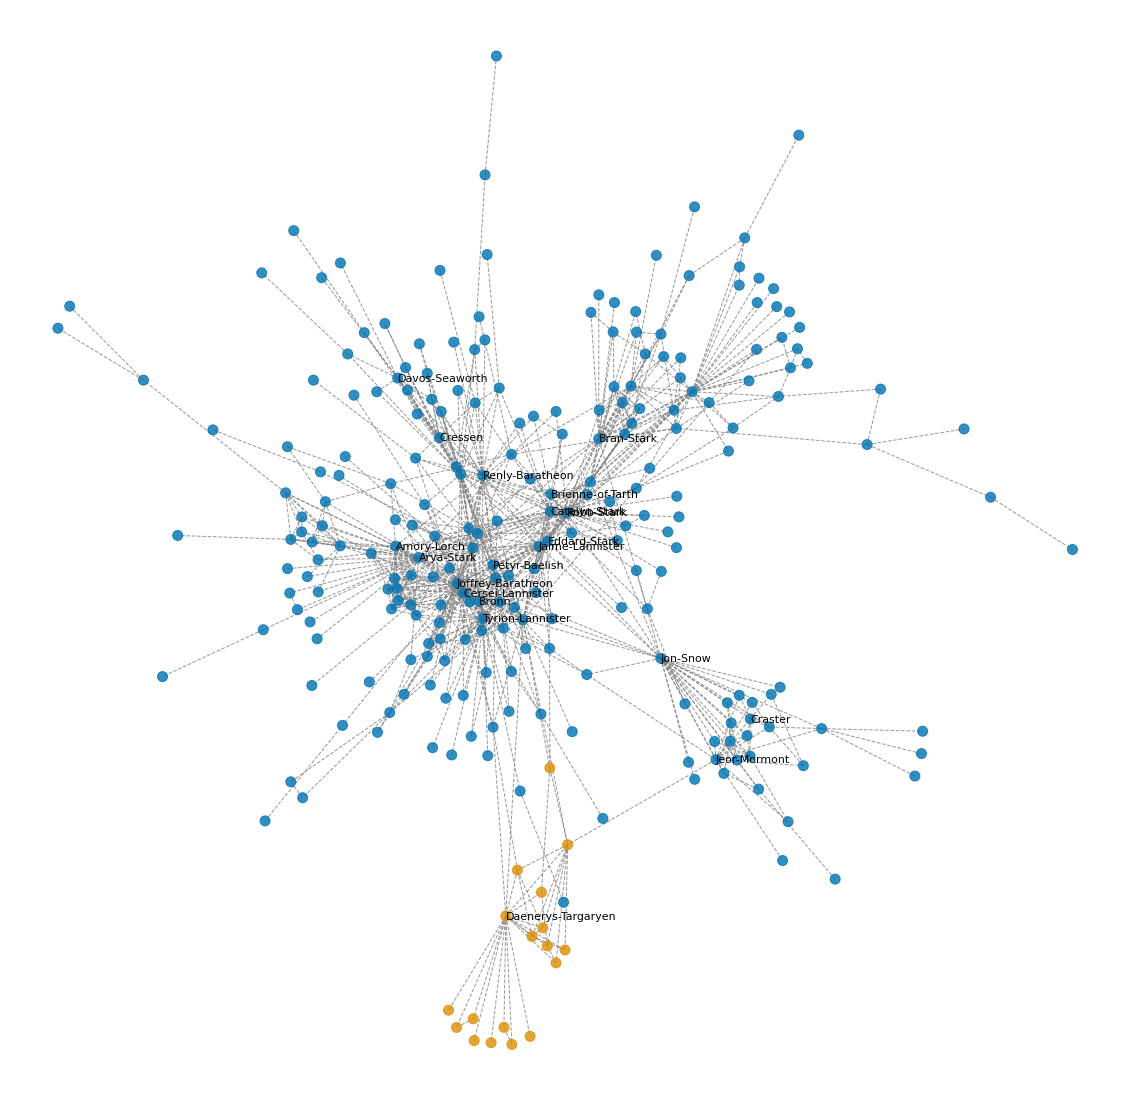

In [883]:
# Plot Figure
fig, ax = plt.subplots(figsize=(20,20))
node_colors, color_map, palette = create_color_map(G2, 'community')
nx.draw(G2, pos2, node_size = 100, alpha = 0.8, edge_color='grey', style ="dashed",node_color=node_colors)
nx.draw_networkx_labels(G2, pos2, labels=label2, font_size=11, alpha=2, horizontalalignment="left")

## K-Clique

In [889]:
comm2 = k_clique_communities(G2, 5, cliques=None)
community_clique2 = list(k_clique_communities(G2, 5, cliques=None))
community_map2 = {}
for node in G2.nodes():
    for i, comm2 in enumerate(community_clique2):
        if node in comm2:
            community_map2[node] = i
    if community_map2.get(node, None) is None:
        community_map2[node] = None
for k, v in community_map2.items():
    G2.nodes[k]['comm'] = v

In [890]:
def create_color_map(G2, attribute, seaborn_palette="colorblind"):

    attr = [G2.nodes[label][attribute] for label in G2.nodes()]
    # get the set of possible attributes
    attr_uniq = list(set(attr))
    vals = len(attr_uniq)
    # generate color palette from seaborn
    palette = color_palette(seaborn_palette, vals).as_hex()
    # create a mapping of attribute to color
    cmap = dict(zip(attr_uniq, palette))
    # map the attribute for each node to the color it represents
    colors = [cmap[attr] for attr in attr]

    return colors, cmap, palette

{'Cersei-Lannister': Text(-0.13322125095914528, -0.06154369055208143, 'Cersei-Lannister'),
 'Bran-Stark': Text(0.11852348349006224, 0.18464059510836484, 'Bran-Stark'),
 'Joffrey-Baratheon': Text(-0.1456728607536117, -0.04613158023455845, 'Joffrey-Baratheon'),
 'Arya-Stark': Text(-0.21680016333110474, -0.005007225725029771, 'Arya-Stark'),
 'Catelyn-Stark': Text(0.028294217462279673, 0.06856590493728973, 'Catelyn-Stark'),
 'Jon-Snow': Text(0.233942671626319, -0.16573397559290154, 'Jon-Snow'),
 'Renly-Baratheon': Text(-0.09752994185963419, 0.12605608191958112, 'Renly-Baratheon'),
 'Eddard-Stark': Text(0.023062161895793146, 0.021135533727420882, 'Eddard-Stark'),
 'Daenerys-Targaryen': Text(-0.054474315224643466, -0.576896057877779, 'Daenerys-Targaryen'),
 'Davos-Seaworth': Text(-0.25573440288093063, 0.2813860885979777, 'Davos-Seaworth'),
 'Jeor-Mormont': Text(0.33663129096131816, -0.32735951430000426, 'Jeor-Mormont'),
 'Jaime-Lannister': Text(0.007019919080145627, 0.013237972943528886, 'Ja

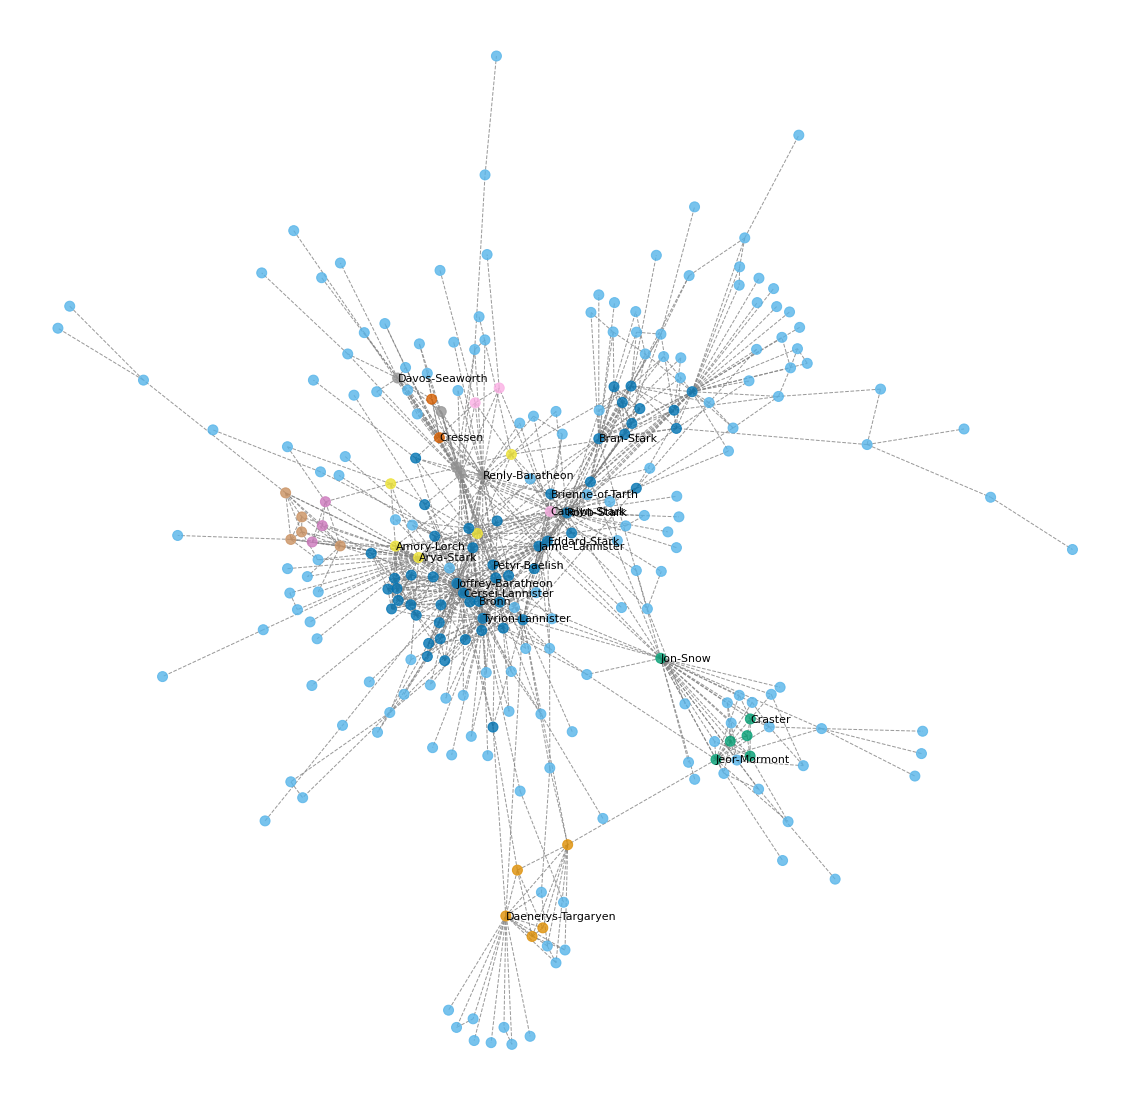

In [892]:
# Plot Figure
fig, ax = plt.subplots(figsize=(20,20))
node_colors, color_map, palette = create_color_map(G2, 'comm')
nx.draw(G2, pos2, node_size = 100, alpha = 0.8, edge_color='grey', style ="dashed",node_color=node_colors)
nx.draw_networkx_labels(G2, pos2, labels=label2, font_size=11, alpha=2, horizontalalignment="left")

## Label Propagation

In [845]:
comm_lab2 = label_propagation_communities(G2)
community_lab2 = list(label_propagation_communities(G2))
comm_ = comm_lab2
community_map3 = {}
for node in G2.nodes():
    for i, comm_ in enumerate(community_lab2):
        if node in comm_:
            community_map3[node] = i
    if community_map3.get(node, None) is None:
        community_map3[node] = None
for k, v in community_map3.items():
    G2.nodes[k]['comm'] = v

{'Eddard-Stark': Text(0.023062161895793146, 0.021135533727420882, 'Eddard-Stark'),
 'Bran-Stark': Text(0.11852348349006224, 0.18464059510836484, 'Bran-Stark'),
 'Catelyn-Stark': Text(0.028294217462279673, 0.06856590493728973, 'Catelyn-Stark'),
 'Arya-Stark': Text(-0.21680016333110474, -0.005007225725029771, 'Arya-Stark'),
 'Daenerys-Targaryen': Text(-0.054474315224643466, -0.576896057877779, 'Daenerys-Targaryen'),
 'Cersei-Lannister': Text(-0.13322125095914528, -0.06154369055208143, 'Cersei-Lannister'),
 'Jon-Snow': Text(0.233942671626319, -0.16573397559290154, 'Jon-Snow'),
 'Joffrey-Baratheon': Text(-0.1456728607536117, -0.04613158023455845, 'Joffrey-Baratheon'),
 'Jaime-Lannister': Text(0.007019919080145627, 0.013237972943528886, 'Jaime-Lannister'),
 'Barristan-Selmy': Text(-0.07830605404189785, -0.2755770867001225, 'Barristan-Selmy'),
 'Robert-Baratheon': Text(-0.022652458446662638, -0.10425441170967038, 'Robert-Baratheon'),
 'Drogo': Text(0.022759414455018757, -0.6248170239273022, 

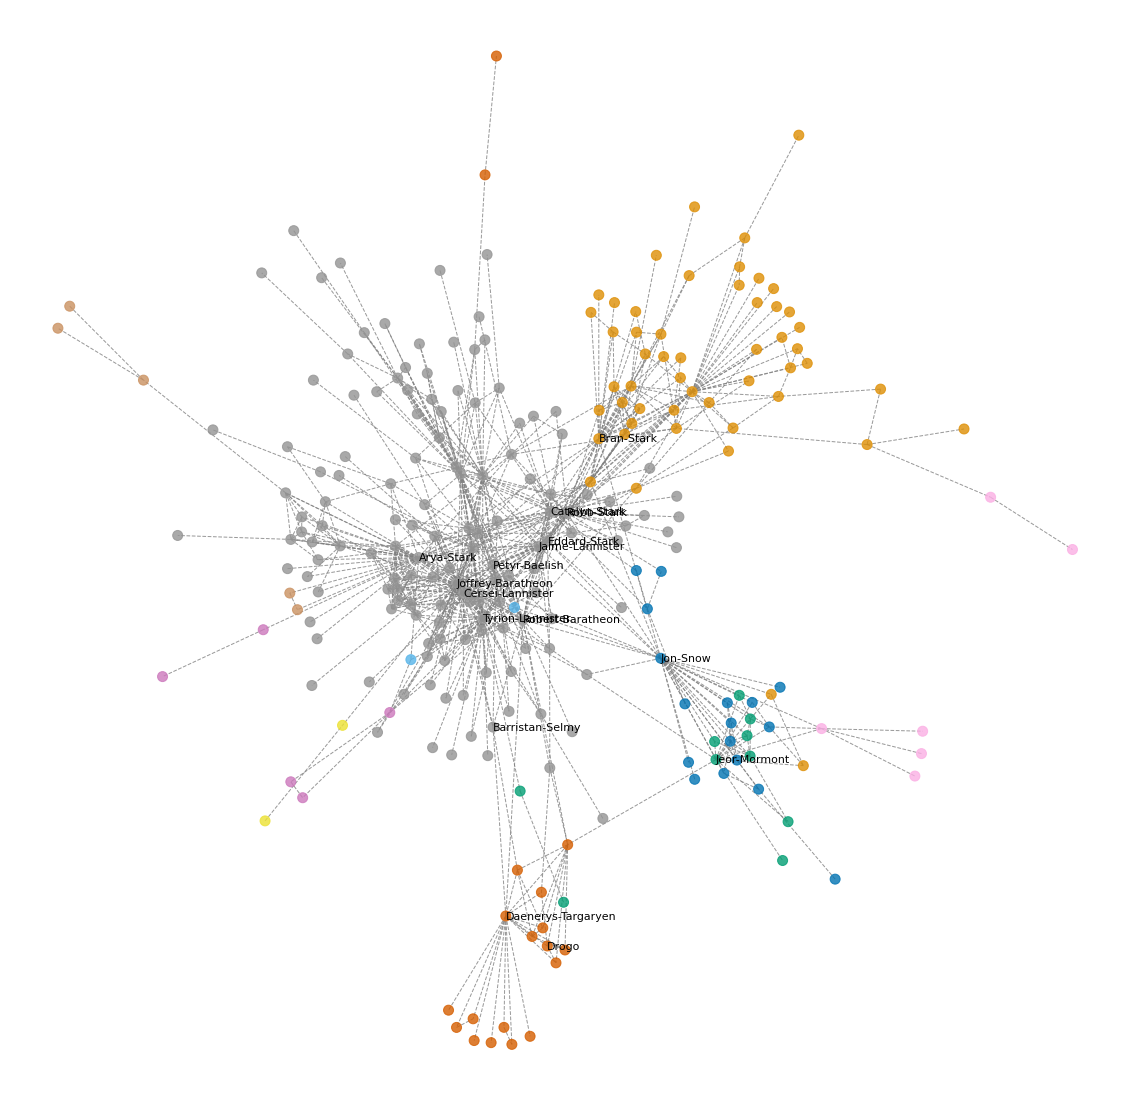

In [848]:
# Plot Figure
fig, ax = plt.subplots(figsize=(20,20))
node_colors, color_map, palette = create_color_map(G2, 'comm')
nx.draw(G2, pos2, node_size = 100, alpha = 0.8, edge_color='grey', style ="dashed",node_color=node_colors)
nx.draw_networkx_labels(G2, pos2, labels=label, font_size=11, alpha=2, horizontalalignment="left")